Notebook purpose

- Sense-check and explore calculated account balances

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
sys.path.append('/Users/fgu/dev/projects/entropy')
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
SAMPLE = 'X77'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = aws.read_parquet(fp)
print(df.shape)
df.head(1)

(1299877, 28)


,id,date,user_id,amount,desc,merchant,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,ym,balance,income
0,688261,2012-01-03,777,400.0,<mdbremoved> - s/o,NaN,transfers,False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-11-13,True,364.220001,non merchant mbl,transfers,other account,other account,201201,2179.515625,24319.220881


## Current accounts

### Raw balances

### Over time

Below shows median of median weekly balances.

In [16]:
def period_balance(
    df,
    period,
    account_types=['current'],
    by = None,
    start='Jan 2016',
    end=None
):
    """Get median period-wise current account balances across all users."""
    grouper = ['account_type'] + [by] if by else ['account_type']
    return (df.loc[df.account_type.isin(account_types)]
            .set_index('date')
            .loc[start:end]
            .groupby(grouper)
            .resample(period).balance.median()
            .unstack(level=0)
            .fillna(method='ffill'))

Aggreate

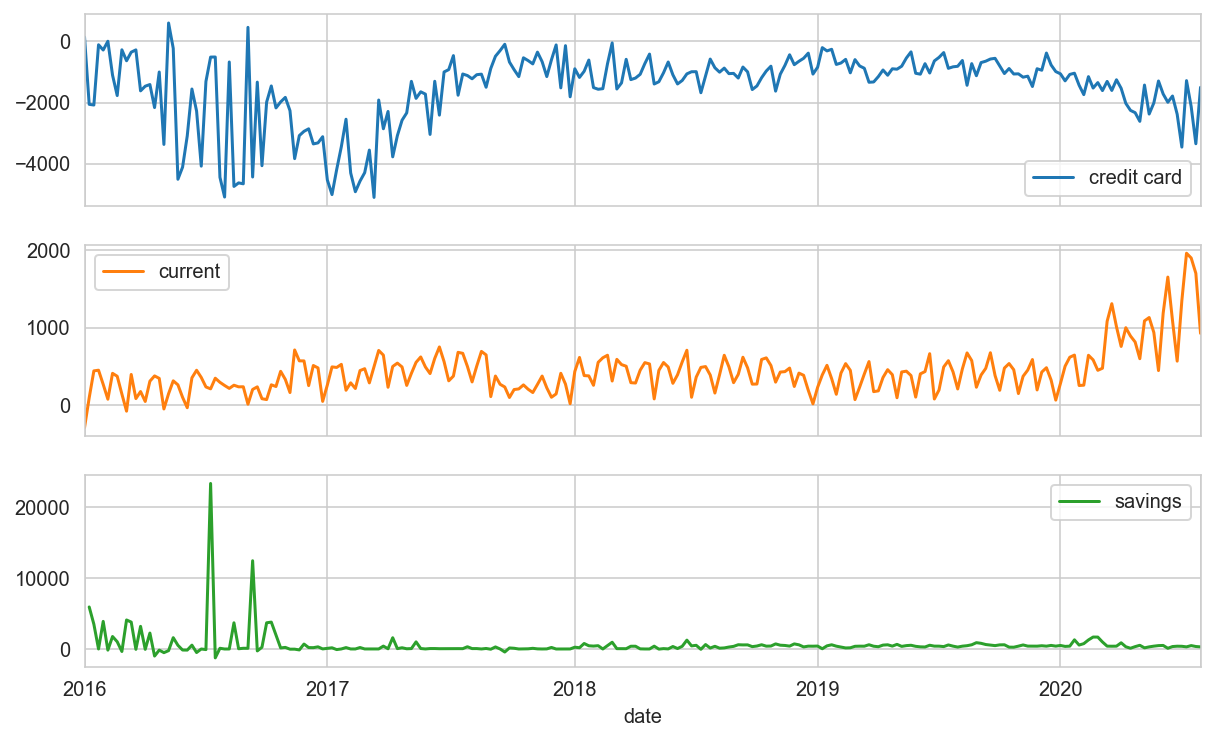

In [19]:
account_types = ['savings', 'current', 'credit card']

(period_balance(df, period='w', account_types=account_types)
 .plot(subplots=True, figsize=(10, 6)));

### By group

Age decade

In [7]:
df['age_decade'] = (2021 - df.user_yob) // 10 * 10
eow_balances_by_group(df, 'age_decade', start_date='Jan 2018').plot(figsize=(10, 4));

Income quartile

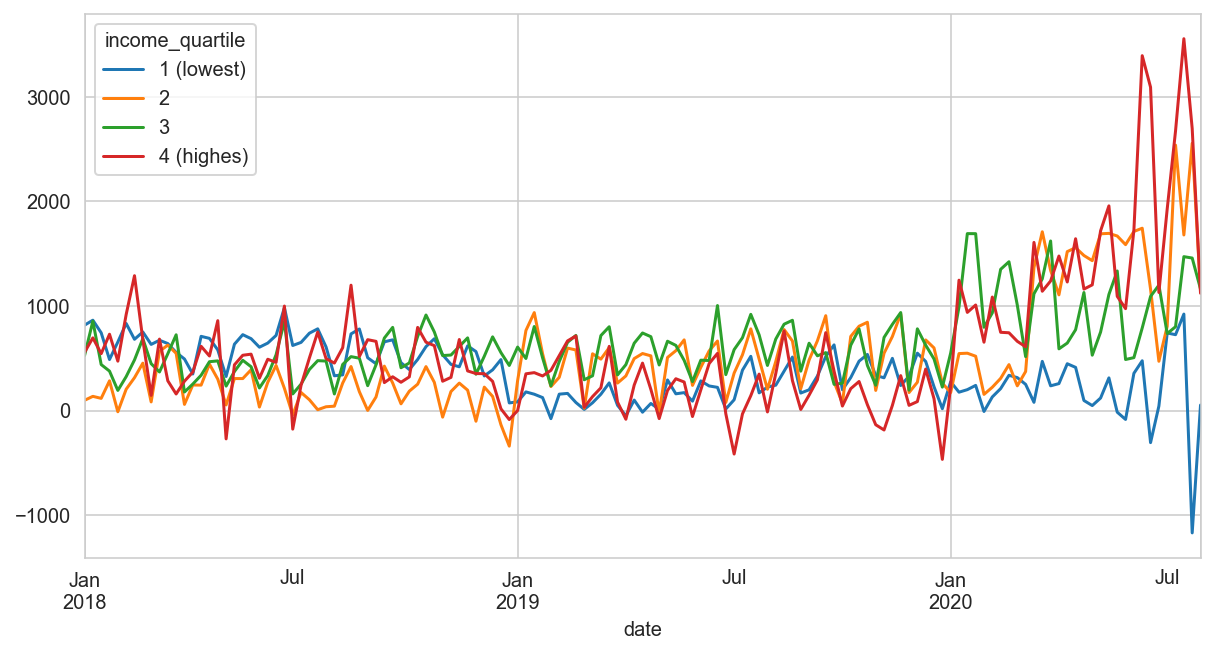

In [8]:
labels = ['1 (lowest)', '2', '3', '4 (highes)']
inc_quartile = (df.groupby([df.date.dt.year, 'user_id'])
                 .income.first()
                 .groupby('date')
                 .apply(pd.qcut, q=4, labels=labels)
                 .reset_index()
                 .rename(columns={'date': 'y', 'income': 'income_quartile'}))

df['y'] = df.date.dt.year
dd = df.merge(inc_quartile, how='left', on=['y', 'user_id'], validate='m:1').drop(columns=['y'])
eow_balances_by_group(dd, 'income_quartile', start_date='Jan 2018').plot(figsize=(10, 5));

## Income-scaled balances

Collapse data to have one row per user and account type per day.

In [224]:
account_type_balances = (df.loc[df.account_type == 'current']
                         .set_index('date')
                         .groupby(['user_id', 'account_id', 'date'])
                         .balance.first()
                         .groupby(['user_id', 'date'])
                         .sum(min_count=1))
monthly_income = df.groupby(['user_id', 'date']).income.first() / 12
scaled_balance = (account_type_balances
                  .div(monthly_income)
                  .rename('scaled_balance')
                  .reset_index())
scaled_balance.head(2)

,user_id,date,scaled_balance
0,777,2012-01-03,1.075453
1,777,2012-01-04,1.084084


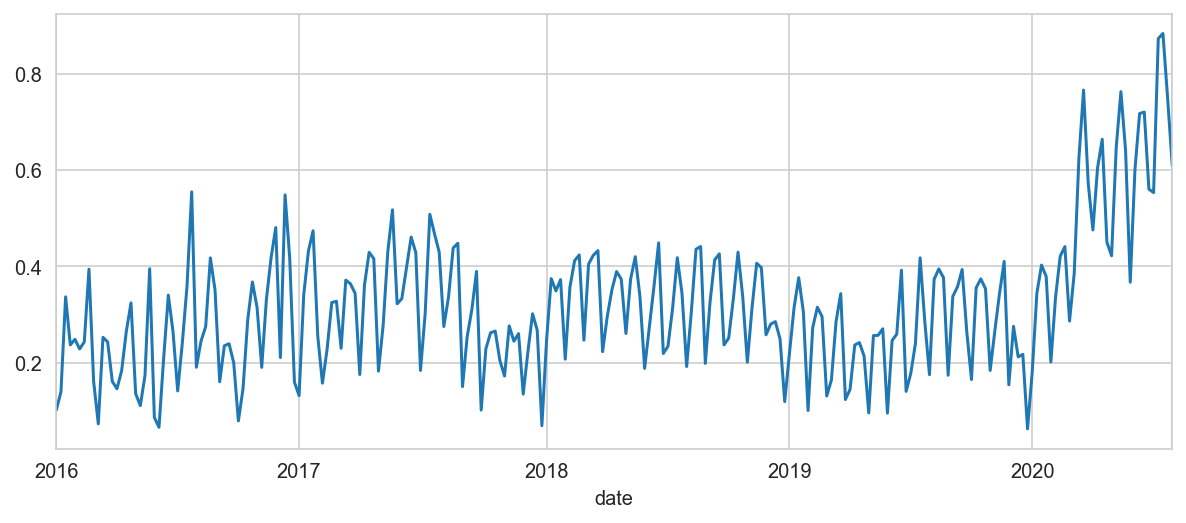

In [232]:
START_DATE, END_DATE = 'Jan 2016', None

(scaled_balance
 .set_index('date')
 .resample('w').scaled_balance.median()
 .loc[START_DATE:END_DATE]
 .plot(figsize=(10, 4)));

### Why are peaks mid-month rather than late/early month around typical payday dates?

In [249]:
PERIOD = 'Jan 2019'

scaled_balance[scaled_balance.user_id == 1977]

,user_id,date,scaled_balance
2534,1977,2012-06-21,NaN
2535,1977,2012-06-22,NaN
2536,1977,2012-06-29,NaN
2537,1977,2012-07-11,NaN
2538,1977,2012-07-20,NaN
...,...,...,...
3366,1977,2016-02-16,NaN
3367,1977,2016-02-17,NaN
3368,1977,2016-02-18,NaN
3369,1977,2016-02-19,NaN


## Case studies

In [4]:
SAMPLE_SIZE = df.user_id.nunique()
SAMPLE_SIZE = 5

user_sample = pd.Series(df.user_id.unique()).sample(random_state=2312, n=SAMPLE_SIZE)
sample = df[df.user_id.isin(user_sample)]

In [5]:
daily_balances = (sample.set_index('date')
                  .groupby(['account_id', 'account_type', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .sort_values('user_id')
                  .assign(account_label=lambda x: x.account_type.astype('str') + '-' + x.account_id.astype('str')))

daily_balances.head(3)

,account_id,account_type,user_id,date,balance,account_label
0,326973,current,228577,2014-09-29,NaN,current-326973
881,326974,savings,228577,2015-05-26,NaN,savings-326974
880,326974,savings,228577,2015-05-25,NaN,savings-326974


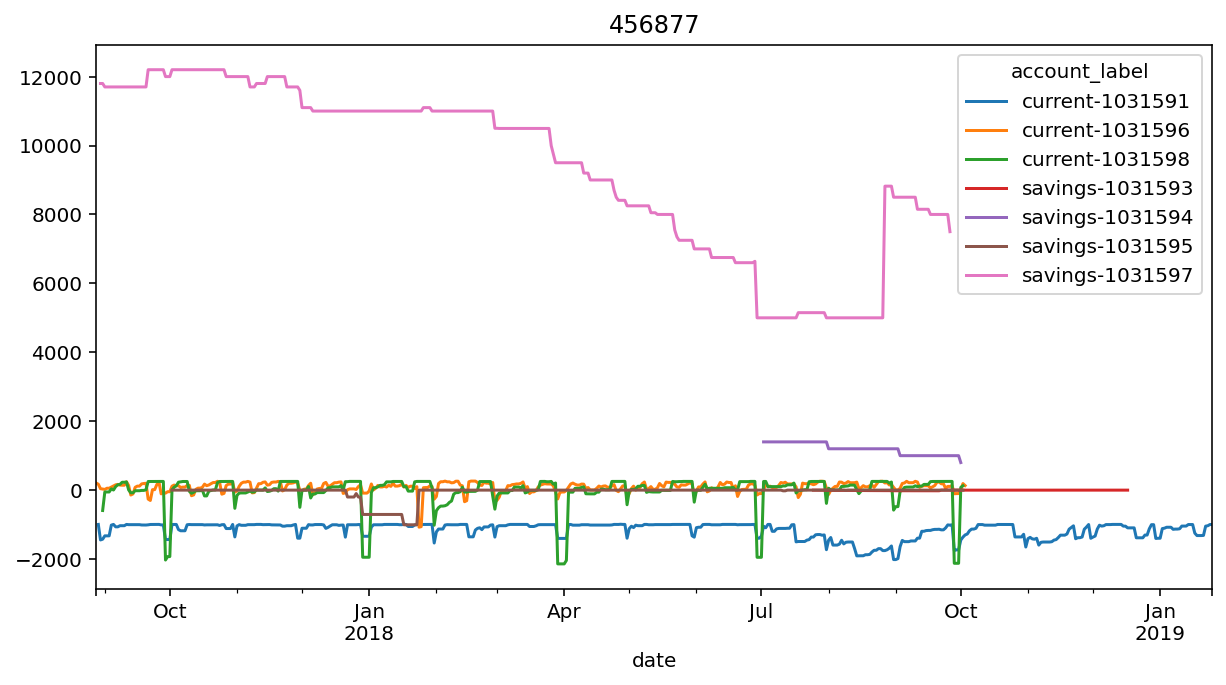

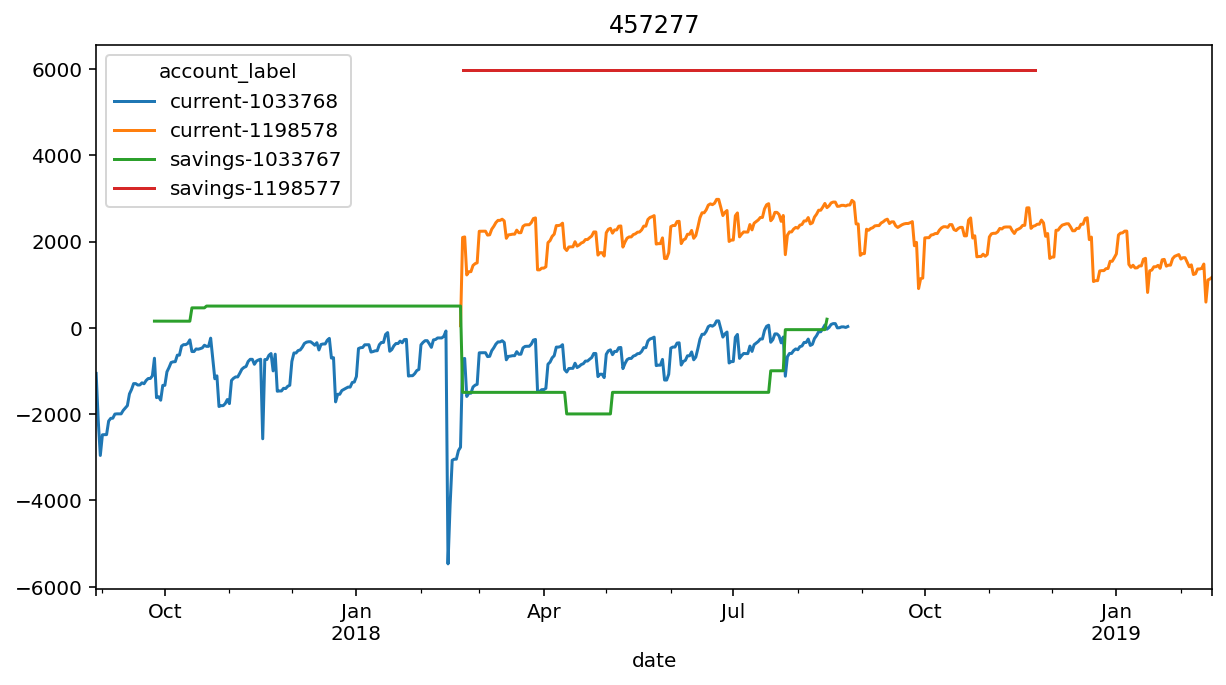

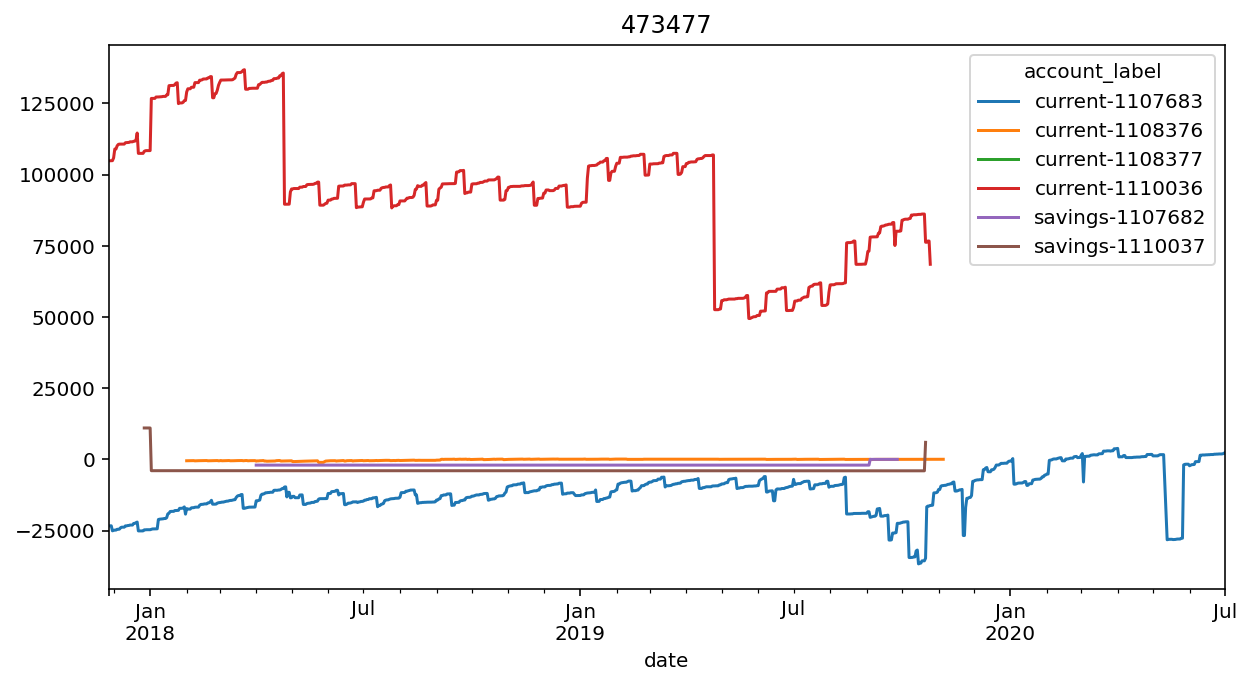

In [6]:
for id, data in daily_balances.groupby('user_id'):
    pivot = data.pivot_table('balance', 'date', 'account_label')
    if not pivot.empty:
        pivot.plot(figsize=(10, 5), title=id);

## Savings account balances

In [3]:
df.groupby('account_id').account_type.first().value_counts()

current        99
savings        60
credit card    30
other           5
Name: account_type, dtype: int64

In [58]:
daily_balances = (df[df.account_type == 'savings']
                  .set_index('date')
                  .groupby(['account_id', 'account_type', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .assign(account_label=lambda x: 
                          x.account_id.astype('str') + '-' 
                          + x.user_id.astype('str')))

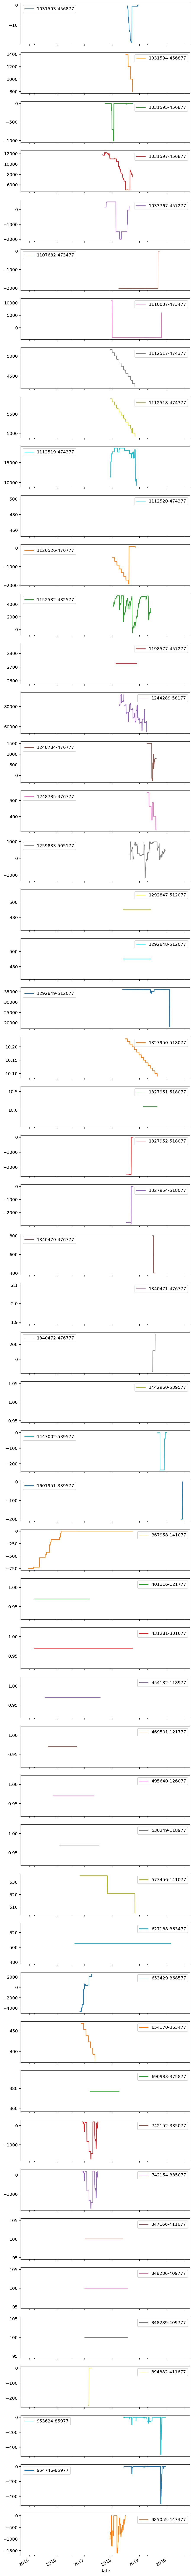

In [57]:
(daily_balances
 .pivot_table('balance', 'date', 'account_label')
 .iloc[:,:]
 .plot(subplots=True, figsize=(7, 120)));